1. Imports & Global Settings

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

from skopt import BayesSearchCV
from joblib import dump

warnings.filterwarnings('ignore', category=FutureWarning)
plt.style.use('seaborn-v0_8-whitegrid')

2: Data Loading, Time-of-Day Bucketing & Round Assignment

In [2]:
usecols = [
    'Time','HomeTeam','AwayTeam','FTHG','FTAG','FTR','Referee',
    'HS','AS','HST','AST','HF','AF','HC','AC','HY','AY','HR','AR',
    'B365H','B365D','B365A','B365>2.5','B365<2.5'
]

file_path = r"D:\python\premier league predictor\premier league data\premier leaguer 21-22.csv"
df = pd.read_csv(file_path, usecols=usecols)

# Assign match index and round number (every 10 matches = one round)
df['MatchIndex'] = df.index + 1
df['Round']      = np.ceil(df['MatchIndex'] / 10).astype(int)

# Convert time to hour and assign time-of-day bucket
df['Hour'] = pd.to_datetime(df['Time'], format='%H:%M', errors='coerce').dt.hour
bins   = [-1, 11, 17, 24]
labels = ['Morning','Afternoon','Evening']
df['TimeOfDay'] = pd.cut(df['Hour'], bins=bins, labels=labels)
df.drop(columns='Hour', inplace=True)

print("Loaded shape:", df.shape)


Loaded shape: (380, 27)


3: Leakage-Free Feature Engineering

In [3]:
# %% [markdown]
# ## Step 3: Leakage-Free Feature Engineering
# Construct predictive features using only historical or observable data at each round.
# Features include outcome mapping, implied probabilities, odds spread, rolling form and streaks,
# interaction terms, referee bias, head-to-head history, rolling match stats, and previous-round positions.

# %%
# 3.1 Targets: match outcome and goal-over-under indicator
df['Outcome'] = df['FTR'].map({'H': 1, 'D': 0, 'A': -1})
df['Over2.5'] = ((df['FTHG'] + df['FTAG']) >= 3).astype(int)

# 3.2 Implied probabilities from betting odds
for side in ['H', 'D', 'A']:
    df[f'ImpProb_{side}'] = 1.0 / df[f'B365{side}']
prob_cols = ['ImpProb_H', 'ImpProb_D', 'ImpProb_A']
df[prob_cols] = df[prob_cols].div(df[prob_cols].sum(axis=1), axis=0)

df['ImpOver2.5']  = 1.0 / df['B365>2.5']
df['ImpUnder2.5'] = 1.0 / df['B365<2.5']
df[['ImpOver2.5', 'ImpUnder2.5']] = (
    df[['ImpOver2.5', 'ImpUnder2.5']]
      .div(df[['ImpOver2.5', 'ImpUnder2.5']].sum(axis=1), axis=0)
)

# 3.3 Odds spread
df['OddsSpread'] = df['B365H'] - df['B365A']

# 3.4 Rolling 3-match form
df['HomeForm3'] = (
    df.groupby('HomeTeam')['Outcome']
      .transform(lambda s: s.shift(1).rolling(3, min_periods=1).mean())
)
df['AwayForm3'] = (
    df.groupby('AwayTeam')['Outcome']
      .transform(lambda s: s.shift(1).rolling(3, min_periods=1).mean())
)

# 3.5 Win/loss streaks
df['HomeStreak'] = (
    df.groupby('HomeTeam')['Outcome']
      .transform(lambda s:
          s.eq(1).shift(1).fillna(0).astype(int)
           .groupby((~s.eq(1)).cumsum()).cumsum()
      )
)
df['AwayStreak'] = (
    df.groupby('AwayTeam')['Outcome']
      .transform(lambda s:
          s.eq(-1).shift(1).fillna(0).astype(int)
           .groupby((~s.eq(-1)).cumsum()).cumsum()
      )
)

# 3.6 Interaction term
df['Spread×Form'] = df['OddsSpread'] * df['HomeForm3']

# 3.7 Referee home-bias estimation
df['RefHomeWins'] = (
    df.groupby('Referee')['Outcome']
      .transform(lambda s: s.eq(1).cumsum().shift(1).fillna(0))
)
df['RefMatches'] = df.groupby('Referee').cumcount()
df['RefBias']    = (df['RefHomeWins'] / df['RefMatches']).fillna(0.5)
df.drop(columns=['RefHomeWins', 'RefMatches'], inplace=True)

# %% [markdown]
# ### Step 3.8: Head-to-Head Last Result
# Track the most recent result between the two teams from the perspective of the home side.

# %%
df['PairKey'] = df.apply(
    lambda r: tuple(sorted([r.HomeTeam, r.AwayTeam])), axis=1
)
h2h = {}
def prev_h2h(row):
    key = row.PairKey
    prev = h2h.get(key, 0)
    sign = 1 if row.HomeTeam == key[0] else -1
    h2h[key] = row.Outcome * sign
    return prev

df['H2H_Last'] = df.apply(prev_h2h, axis=1)
df.drop(columns='PairKey', inplace=True)

# %% [markdown]
# ### Step 3.9: Rolling Match-Stat Averages
# Compute rolling 3-match averages for key match statistics (shots, fouls, cards).

# %%
home_stats = ['HS','HST','HF','HC','HY','HR']
away_stats = ['AS','AST','AF','AC','AY','AR']
for stat in home_stats:
    df[f'Home_{stat}_3'] = (
        df.groupby('HomeTeam')[stat]
          .transform(lambda s: s.shift(1).rolling(3, min_periods=1).mean())
    )
for stat in away_stats:
    df[f'Away_{stat}_3'] = (
        df.groupby('AwayTeam')[stat]
          .transform(lambda s: s.shift(1).rolling(3, min_periods=1).mean())
    )

# %% [markdown]
# ### Step 3.10: Previous-Round Table Position
# Calculate each team’s cumulative points and league position as of the previous round.

# %%
df['HomePts'] = np.where(df['FTR']=='H', 3, np.where(df['FTR']=='D', 1, 0))
df['AwayPts'] = np.where(df['FTR']=='A', 3, np.where(df['FTR']=='D', 1, 0))

pts = pd.DataFrame({
    'Team':  np.concatenate([df['HomeTeam'], df['AwayTeam']]),
    'Round': np.concatenate([df['Round'],    df['Round']]),
    'Pts':   np.concatenate([df['HomePts'],  df['AwayPts']])
})
round_pts = (
    pts.groupby(['Team','Round'], as_index=False)['Pts']
        .sum()
)
round_pts['CumPts'] = round_pts.groupby('Team')['Pts'].cumsum()
round_pts['Pos']    = (
    round_pts.groupby('Round')['CumPts']
        .rank(method='min', ascending=False)
)

prev = round_pts[['Team','Round','Pos']].copy()
prev.rename(columns={'Round':'PrevRound','Pos':'PrevPos'}, inplace=True)
prev['PrevRound'] += 1

df = df.merge(
    prev, left_on=['HomeTeam','Round'],
    right_on=['Team','PrevRound'], how='left'
)
df['HomePosPrev'] = df['PrevPos'].fillna(df['Round'].max() + 1)
df.drop(columns=['Team','PrevRound','PrevPos'], inplace=True)

df = df.merge(
    prev, left_on=['AwayTeam','Round'],
    right_on=['Team','PrevRound'], how='left'
)
df['AwayPosPrev'] = df['PrevPos'].fillna(df['Round'].max() + 1)
df.drop(columns=['Team','PrevRound','PrevPos'], inplace=True)

4: Pipeline Specification & Bayesian Hyperparameter Space

In [4]:
from skopt.space import Real, Categorical

# 4.1 Feature lists
cat_feats = ['HomeTeam', 'AwayTeam', 'Referee', 'TimeOfDay']

num_feats = [
    'HomeForm3','AwayForm3','HomeStreak','AwayStreak',
    'ImpProb_H','ImpProb_D','ImpProb_A',
    'ImpOver2.5','ImpUnder2.5',
    'OddsSpread','Spread×Form','RefBias','H2H_Last',
    'HomePosPrev','AwayPosPrev'
] + [f'Home_{s}_3' for s in home_stats] + [f'Away_{s}_3' for s in away_stats]

# 4.2 Fill missing numeric feature values
df[num_feats] = df[num_feats].fillna(0)

# 4.3 Preprocessor: scale numeric features, one-hot encode categoricals
preprocessor = ColumnTransformer([
    ('num', StandardScaler(), num_feats),
    ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), cat_feats),
], remainder='drop')

# 4.4 Bayesian hyperparameter search space
param_space = {
    'clf__C':             Real(1e-3, 1e2, prior='log-uniform'),
    'clf__penalty':       Categorical(['l1', 'l2']),
    'clf__fit_intercept': Categorical([True, False]),
    'clf__solver':        Categorical(['saga'])
}

# 4.5 Model‐building function
def make_model_bayes_lr():
    return Pipeline([
        ('prep', preprocessor),
        ('clf', LogisticRegression(
            solver='saga',
            max_iter=5000,
            random_state=42
        ))
    ])

5: Round-by-Round Training & Prediction with Bayesian Tuning

In [5]:
preds, actuals, rounds, match_indices = [], [], [], []
warmup = 50   # number of initial matches for a quick default fit

# 5.1 Warm-up fit with default Bayesian Logistic Regression (no tuning)
model = make_model_bayes_lr()
model.fit(
    df.loc[:warmup-1, cat_feats + num_feats],
    df.loc[:warmup-1, 'Outcome']
)

# 5.2 Round-by-round loop with BayesSearchCV
for r in range(6, df['Round'].max() + 1):
    train_idx = df['Round'] < r
    test_idx  = df['Round'] == r

    X_train, y_train = df.loc[train_idx, cat_feats + num_feats], df.loc[train_idx, 'Outcome']
    X_test,  y_test  = df.loc[test_idx,  cat_feats + num_feats], df.loc[test_idx,  'Outcome']

    search = BayesSearchCV(
        estimator=make_model_bayes_lr(),
        search_spaces=param_space,
        n_iter=20,
        cv=3,
        scoring='accuracy',
        n_jobs=-1,
        random_state=42
    )
    search.fit(X_train, y_train)
    model = search.best_estimator_

    y_pred = model.predict(X_test)
    preds.extend(y_pred.tolist())
    actuals.extend(y_test.tolist())
    rounds.extend([r] * len(y_test))
    match_indices.extend(df.loc[test_idx, 'MatchIndex'].tolist())

    acc = accuracy_score(y_test, y_pred)
    print(f"Round {r}: accuracy = {acc:.3f}")

print(f"Predicted rounds 6 to {df['Round'].max()}")

# Save the final trained model for later use
final_model = model

Round 6: accuracy = 0.600
Round 7: accuracy = 0.300
Round 8: accuracy = 0.300
Round 9: accuracy = 0.500
Round 10: accuracy = 0.600
Round 11: accuracy = 0.300
Round 12: accuracy = 0.500
Round 13: accuracy = 0.400
Round 14: accuracy = 0.500
Round 15: accuracy = 0.900
Round 16: accuracy = 0.800
Round 17: accuracy = 0.500
Round 18: accuracy = 0.600
Round 19: accuracy = 0.600
Round 20: accuracy = 0.500
Round 21: accuracy = 0.400
Round 22: accuracy = 0.300
Round 23: accuracy = 0.400
Round 24: accuracy = 0.400
Round 25: accuracy = 0.700
Round 26: accuracy = 0.400
Round 27: accuracy = 0.900
Round 28: accuracy = 0.700
Round 29: accuracy = 0.700
Round 30: accuracy = 0.400
Round 31: accuracy = 0.700
Round 32: accuracy = 0.700
Round 33: accuracy = 0.800
Round 34: accuracy = 0.600
Round 35: accuracy = 0.500
Round 36: accuracy = 0.700
Round 37: accuracy = 0.400
Round 38: accuracy = 0.600
Predicted rounds 6 to 38


6: Assemble Results & Save Final Model

In [6]:
# 6.1 Assemble DataFrame of predictions
df_idx = df.set_index('MatchIndex')
homes  = [df_idx.loc[i, 'HomeTeam']  for i in match_indices]
aways  = [df_idx.loc[i, 'AwayTeam']  for i in match_indices]

results_df = pd.DataFrame({
    'MatchIndex': match_indices,
    'Round':       rounds,
    'HomeTeam':    homes,
    'AwayTeam':    aways,
    'Actual':      actuals,
    'Predicted':   preds
})

# Map numeric codes back to labels
label_map = {1: 'H', 0: 'D', -1: 'A'}
results_df['ActualLabel'] = results_df['Actual'].map(label_map)
results_df['PredLabel']   = results_df['Predicted'].map(label_map)

# 6.2 Save predictions to Excel
output_path = r"D:\python\premier league predictor\bayes_lr_predictions.xlsx"
results_df.to_excel(output_path, index=False)
print("Predictions written to", output_path)

# 6.3 Save the final trained Bayesian LR pipeline
model_path = r"D:\python\premier league predictor\bayes_lr_pipeline.joblib"
dump(final_model, model_path)
print("Final Bayesian Logistic Regression pipeline saved to", model_path)

Predictions written to D:\python\premier league predictor\bayes_lr_predictions.xlsx
Final Bayesian Logistic Regression pipeline saved to D:\python\premier league predictor\bayes_lr_pipeline.joblib


7: Results & Visualization

C:\Users\markf\AppData\Local\Temp\ipykernel_16700\2361411492.py:21: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  round_acc = res.groupby('Round').apply(lambda g: accuracy_score(g['True'], g['Pred']))


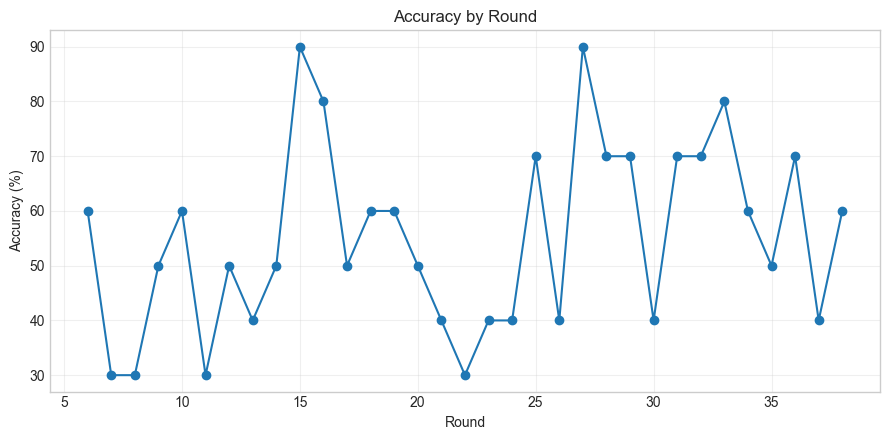

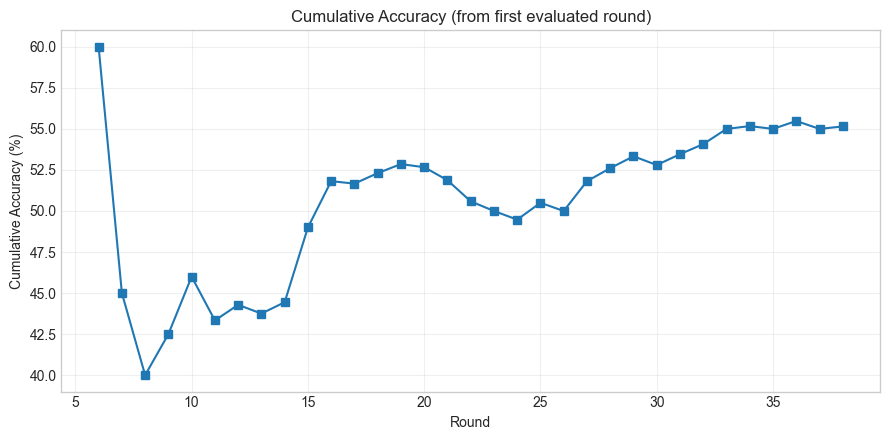


Overall accuracy (rounds 6–38): 0.552
Text summary: The model achieved an overall accuracy of 55.2% across rounds 6–38.

Classification report (labels: H=1, D=0, A=-1):
              precision    recall  f1-score   support

           1      0.621     0.709     0.662       141
           0      0.267     0.156     0.197        77
          -1      0.565     0.625     0.593       112

    accuracy                          0.552       330
   macro avg      0.484     0.497     0.484       330
weighted avg      0.519     0.552     0.530       330


Confusion matrix (rows=actual, cols=predicted) [H=1, D=0, A=-1]:
[[100  18  23]
 [ 34  12  31]
 [ 27  15  70]]


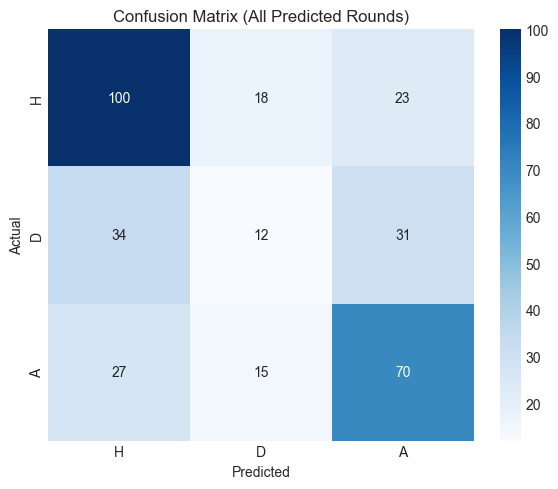

In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Build DataFrame with predictions collected in point 5
res = pd.DataFrame({
    'Round': rounds,
    'Pred': preds,
    'True': actuals
}).sort_values('Round')

# Safety: check that every evaluated round has exactly 10 matches
round_sizes = res.groupby('Round').size()
if not np.all(round_sizes.values == 10):
    print("WARNING: Some rounds do not have exactly 10 matches in the evaluation:")
    print(round_sizes[round_sizes != 10])

# Per-round accuracy (guaranteed denominator is 10 if point 5 enforced it)
round_acc = res.groupby('Round').apply(lambda g: accuracy_score(g['True'], g['Pred']))
round_acc = round_acc.sort_index()

# Cumulative (running) accuracy across predicted rounds
# running_correct / running_total
res['Correct'] = (res['True'] == res['Pred']).astype(int)
cum = res.groupby('Round')['Correct'].sum().cumsum()
cum_total = np.arange(1, len(cum) + 1) * 10  # 10 matches per round by construction
cumulative_acc = (cum / cum_total).rename('CumulativeAccuracy')

# --- Plot: Accuracy by Round ---
plt.figure(figsize=(9, 4.5))
plt.plot(round_acc.index, round_acc.values * 100, marker='o')
plt.xlabel('Round')
plt.ylabel('Accuracy (%)')
plt.title('Accuracy by Round')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# --- Plot: Cumulative Accuracy ---
plt.figure(figsize=(9, 4.5))
plt.plot(cumulative_acc.index, cumulative_acc.values * 100, marker='s')
plt.xlabel('Round')
plt.ylabel('Cumulative Accuracy (%)')
plt.title('Cumulative Accuracy (from first evaluated round)')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# --- Overall accuracy (text) ---
overall_acc = accuracy_score(res['True'], res['Pred'])
print(f"\nOverall accuracy (rounds {int(res['Round'].min())}–{int(res['Round'].max())}): {overall_acc:.3f}")
print(f"Text summary: The model achieved an overall accuracy of {overall_acc*100:.1f}% "
      f"across rounds {int(res['Round'].min())}–{int(res['Round'].max())}.")

# --- Classification report (informative only) ---
print("\nClassification report (labels: H=1, D=0, A=-1):")
print(classification_report(res['True'], res['Pred'], labels=[1,0,-1], digits=3))

# --- Confusion matrix (numbers + heatmap) ---
cm = confusion_matrix(res['True'], res['Pred'], labels=[1,0,-1])
print("\nConfusion matrix (rows=actual, cols=predicted) [H=1, D=0, A=-1]:")
print(cm)

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['H','D','A'], yticklabels=['H','D','A'])
plt.title('Confusion Matrix (All Predicted Rounds)')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.tight_layout()
plt.show()

8: Gradio Interface

In [8]:
import gradio as gr
import pandas as pd
import numpy as np

# 8.1 Precompute training‐set means for odds‐derived features
odd_feats = [
    'ImpProb_H','ImpProb_D','ImpProb_A',
    'ImpOver2.5','ImpUnder2.5','OddsSpread'
]
odd_means = df[odd_feats].mean()

# 8.2 Dropdown choices for UI
teams = sorted(df['HomeTeam'].unique())
refs  = sorted(df['Referee'].unique())
times = ['Morning','Afternoon','Evening']

# 8.3 Prediction function
def predict_outcome(home_team, away_team, referee, time_of_day):
    # Pull last historical record for each entity
    home = df[df.HomeTeam == home_team].iloc[-1]
    away = df[df.AwayTeam == away_team].iloc[-1]
    ref  = df[df.Referee   == referee].iloc[-1]
    
    # Assemble feature dict
    data = {}
    # Odds‐derived features: fill with training‐set means
    for feat in odd_feats:
        data[feat] = odd_means[feat]
    # Rolling form & streaks
    data['HomeForm3']  = home['HomeForm3']
    data['AwayForm3']  = away['AwayForm3']
    data['HomeStreak'] = home['HomeStreak']
    data['AwayStreak'] = away['AwayStreak']
    # Interaction term
    data['Spread×Form'] = data['OddsSpread'] * data['HomeForm3']
    # Referee bias
    data['RefBias'] = ref['RefBias']
    # Head‐to‐head last
    mask = ((df.HomeTeam==home_team)&(df.AwayTeam==away_team)) | \
           ((df.HomeTeam==away_team)&(df.AwayTeam==home_team))
    data['H2H_Last'] = df[mask].iloc[-1]['H2H_Last']
    # Previous‐round positions
    data['HomePosPrev'] = home['HomePosPrev']
    data['AwayPosPrev'] = away['AwayPosPrev']
    # Rolling match stats
    for s in home_stats:
        data[f'Home_{s}_3'] = home[f'Home_{s}_3']
    for s in away_stats:
        data[f'Away_{s}_3'] = away[f'Away_{s}_3']
    # Categorical features
    data['HomeTeam']  = home_team
    data['AwayTeam']  = away_team
    data['Referee']   = referee
    data['TimeOfDay'] = time_of_day
    
    # Predict probabilities
    Xnew    = pd.DataFrame([data])
    probs   = final_model.predict_proba(Xnew)[0]
    classes = list(final_model.classes_)  # [-1,0,1]
    
    return (
        float(probs[classes.index(1)] * 100),
        float(probs[classes.index(0)] * 100),
        float(probs[classes.index(-1)] * 100)
    )

# 8.4 Launch Gradio interface
iface = gr.Interface(
    fn=predict_outcome,
    inputs=[
        gr.Dropdown(teams, label="Home Team"),
        gr.Dropdown(teams, label="Away Team"),
        gr.Dropdown(refs,  label="Referee"),
        gr.Dropdown(times, label="Time of Day"),
    ],
    outputs=[
        gr.Number(label="Home Win %"),
        gr.Number(label="Draw %"),
        gr.Number(label="Away Win %")
    ],
    title="Premier League Outcome Predictor (Bayesian LR)",
    description=(
        "Select Home/Away teams, Referee and Time of Day. "
        "Odds‐derived features are filled with their historical averages, "
        "all other features are pulled from past matches."
    )
)

iface.launch()

* Running on local URL:  http://127.0.0.1:7874

To create a public link, set `share=True` in `launch()`.
